In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from collections import Counter
from tempfile import TemporaryDirectory
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR, OneCycleLR
import random
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, f1_score

cudnn.benchmark = True
plt.ion()   # interactive mode

Load Data
========


In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

In [ ]:
# Hyperparameters
num_epochs = 2
lr= 1e-3  # higher lr for classifier
momentum = 0.9
step_size = 7 
gamma = 0.1
weight_decay = 1e-4
batch_size = 64
patience = 2
label_smoothing = 0.05
warmup_epochs = 2

In [ ]:
# Load the .npy dataset
path_to_fer = 'fer13_v2.npy'
m = np.load(path_to_fer, allow_pickle=True).item()
x_train, y_train = m['train']
x_val, y_val = m['val']
x_test, y_test = m['test']

In [ ]:

# Count the number of samples per class for each dataset
train_counts = Counter(y_train)
val_counts = Counter(y_val)
test_counts = Counter(y_test)

# Get sorted class labels
class_labels = sorted(set(y_train) | set(y_val) | set(y_test))

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.25
index = np.arange(len(class_labels))

ax.bar(index, [train_counts[c] for c in class_labels], bar_width, label='Train')
ax.bar(index + bar_width, [val_counts[c] for c in class_labels], bar_width, label='Validation')
ax.bar(index + 2 * bar_width, [test_counts[c] for c in class_labels], bar_width, label='Test')

ax.set_xlabel('Class Label')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(class_labels)
ax.legend()

plt.show()

In [ ]:

TARGET_COUNT = 4000

# Count the number of samples per class in training set
train_counts = Counter(y_train)

# Data augmentation for training set
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((384, 384), interpolation=InterpolationMode.BILINEAR),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
    # transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match EfficientNet normalization
])

# **No augmentation for validation and test sets**
val_test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((384, 384), interpolation=InterpolationMode.BILINEAR),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Balance dataset by removing excess images and augmenting underrepresented classes
balanced_x_train = []
balanced_y_train = []

for label in train_counts:
    indices = [i for i, y in enumerate(y_train) if y == label]
    if train_counts[label] > TARGET_COUNT:
        # Randomly select TARGET_COUNT images
        selected_indices = random.sample(indices, TARGET_COUNT)
    else:
        # Keep all images and perform augmentation to reach TARGET_COUNT
        selected_indices = indices.copy()
        while len(selected_indices) < TARGET_COUNT:
            selected_indices.append(random.choice(indices))
    
    for idx in selected_indices:
        balanced_x_train.append(x_train[idx])
        balanced_y_train.append(y_train[idx])

# Convert balanced dataset to numpy arrays
balanced_x_train = np.array(balanced_x_train)
balanced_y_train = np.array(balanced_y_train)

# Define dataset class
class FERDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].astype(np.uint8)
        label = int(self.labels[idx])
        return self.transform(image), label

# Create datasets with appropriate transforms
datasets = {
    'train': FERDataset(balanced_x_train, balanced_y_train, transform=train_transforms),
    'val': FERDataset(x_val, y_val, transform=val_test_transforms),  # No augmentation
    'test': FERDataset(x_test, y_test, transform=val_test_transforms)  # No augmentation
}

# Get the number of unique classes in the dataset
num_classes = len(np.unique(np.concatenate([y_train, y_val, y_test])))

print(f"Number of classes: {num_classes}")

# Create dataloaders
dataloaders = {
    x: DataLoader(datasets[x], batch_size=batch_size, shuffle=(x == 'train'), num_workers=4)
    for x in ['train', 'val', 'test']
}

# Count final dataset sizes
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}

print(f"Final dataset sizes: {dataset_sizes}")


In [ ]:
dataset_sizes

Visualize a few images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.


In [ ]:
def show_sample_images(dataloader, num_images=6):
    images_shown = 0
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for images, labels in dataloader:
        for i in range(num_images):
            image = images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5
            axes[i].imshow(image, cmap='gray')
            axes[i].set_title(f"Label: {labels[i]}")
            axes[i].axis('off')
            images_shown += 1
            if images_shown >= num_images:
                plt.show()
                return
            
# Show sample images
show_sample_images(dataloaders['train'])

Training the model
==================

Now, let\'s write a general function to train a model. Here, we will
illustrate:

-   Scheduling the learning rate
-   Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from
`torch.optim.lr_scheduler`.


In [ ]:

# Function to calculate combined metric
def calculate_combined_metric(accuracy, f1_score):
    return 0.5 * (accuracy + f1_score)

# Modified training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5, grad_clip=1.0):
    since = time.time()
    
    # Create models directory
    model_dir = "models"
    os.makedirs(model_dir, exist_ok=True)
    best_model_path = os.path.join(model_dir, 'best_model.pth')
    
    best_combined_metric = 0.0
    patience_counter = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_f1_scores, val_f1_scores = [], []
    train_combined_metrics, val_combined_metrics = [], []
    learning_rates = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []
            
            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        # Gradient clipping to prevent exploding gradients
                        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Collect predictions and labels for F1 score
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            
            # Step the scheduler after the epoch (for OneCycleLR)
            if phase == 'train':
                scheduler.step()
                # Log the learning rate
                current_lr = optimizer.param_groups[0]['lr']
                learning_rates.append(current_lr)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
            epoch_combined_metric = calculate_combined_metric(epoch_acc.item(), epoch_f1)
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
                train_f1_scores.append(epoch_f1)
                train_combined_metrics.append(epoch_combined_metric)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())
                val_f1_scores.append(epoch_f1)
                val_combined_metrics.append(epoch_combined_metric)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f} Combined: {epoch_combined_metric:.4f}')
            
            if phase == 'val' and epoch_combined_metric > best_combined_metric:
                best_combined_metric = epoch_combined_metric
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'best_combined_metric': best_combined_metric,
                }, best_model_path)
                patience_counter = 0  # Reset early stopping counter
            elif phase == 'val':
                patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Combined Metric: {best_combined_metric:.4f}')
    
    # Load best model
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Plot training results
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')
    
    plt.subplot(2, 3, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')
    
    plt.subplot(2, 3, 3)
    plt.plot(train_f1_scores, label='Train F1')
    plt.plot(val_f1_scores, label='Val F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('Training & Validation F1 Score')
    
    plt.subplot(2, 3, 4)
    plt.plot(train_combined_metrics, label='Train Combined')
    plt.plot(val_combined_metrics, label='Val Combined')
    plt.xlabel('Epochs')
    plt.ylabel('Combined Metric')
    plt.legend()
    plt.title('Training & Validation Combined Metric')
    
    plt.subplot(2, 3, 5)
    plt.plot(learning_rates, label='Learning Rate')
    plt.xlabel('Steps')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.title('Learning Rate Schedule')
    
    plt.tight_layout()
    plt.show()
    
    return model

Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [ ]:
# Function to unnormalize and show an image
def imshow(img):
    """Display a tensor image (Grayscale or RGB)"""
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor format (C, H, W) to (H, W, C)
    img = img * 0.5 + 0.5  # Unnormalize (assuming Normalize([0.5], [0.5]))
    
    if img.shape[-1] == 1:  # If the image is grayscale, remove the last dimension
        img = img.squeeze(-1)
    
    plt.imshow(img, cmap="gray" if len(img.shape) == 2 else None)  # Use 'gray' colormap if grayscale
    plt.axis("off")

# Function to visualize model predictions
def visualize_model(model, num_images=6):
    """Visualizes model predictions on the validation set"""
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, num_images * 2))

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot((num_images + 1) // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f'Predicted: {preds[j].item()} | True: {labels[j].item()}')
                
                imshow(inputs.cpu().data[j])  # Show image

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
    model.train(mode=was_training)

In [ ]:
def evaluate_model(model, dataloader, num_classes, device):
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []
    y_prob = []  # Store probability scores for AUC calculation

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Forward pass

            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            _, preds = torch.max(outputs, 1)  # Get predicted class

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())  # Store probabilities

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Compute classification report (Precision, Recall, F1-score)
    class_report = classification_report(y_true, y_pred, digits=4)

    # Compute Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    f1 = f1_score(y_true, y_pred, average='weighted')

    # Compute new metric: 0.5*(Accuracy + F1)
    combined_metric = 0.5 * (accuracy + f1)

    # Compute AUC (for multi-class classification using One-vs-Rest)
    y_true_bin = np.eye(num_classes)[y_true]  # Convert to one-hot encoding
    auc_score = roc_auc_score(y_true_bin, np.array(y_prob), multi_class="ovr")

    return cm, accuracy, auc_score, class_report, combined_metric


# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_labels, normalize=False):
    plt.figure(figsize=(9, 8))
    
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row
    
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title("Confusion Matrix", fontsize=20)
    plt.colorbar()

    # Add text annotations
    fmt = ".2f" if normalize else "d"
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            plt.text(j, i, format(cm[i, j], fmt), ha="center", va="center", 
                     color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
    plt.yticks(np.arange(len(class_labels)), class_labels)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("Actual Label", fontsize=14)
    plt.show()

Finetuning the ConvNet
======================


### Model with final fully connected layer.

We freeze the entire model and unfreeze the classifier

In [ ]:
# Step 1: Load and modify the model
model_ft = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
num_ftrs = model_ft.classifier[1].in_features

# Define a small FCN classifier
model_ft.classifier = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout before the first layer
    nn.Linear(num_ftrs, 512),  # First hidden layer
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, num_classes)  # Output layer
)

# Freeze entire model first
for param in model_ft.parameters():
    param.requires_grad = False

# Unfreeze classifier parameters
for param in model_ft.classifier.parameters():
    param.requires_grad = True

model_ft = model_ft.to(device)

# Define loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

# Step 4: Set up optimizer (AdamW is better for weight decay handling)
optimizer_ft = optim.AdamW(model_ft.classifier.parameters(), lr=lr, weight_decay=weight_decay)

# Step 5: One-cycle learning rate scheduler (more stable than cosine)
scheduler = OneCycleLR(optimizer_ft, 
                      max_lr=1e-3, 
                      steps_per_epoch=len(dataloaders['train']), 
                      epochs=num_epochs, 
                      pct_start=0.1)  # Warm-up for 10% of training



#### Train and evaluate
==================

train Loss: 1.9133 Acc: 0.2139 F1: 0.2093 Combined: 0.2116
val Loss: 1.8562 Acc: 0.2580 F1: 0.2336 Combined: 0.2458

Epoch 1/1
----------
train Loss: 1.8235 Acc: 0.2799 F1: 0.2678 Combined: 0.2739
val Loss: 1.8359 Acc: 0.2898 F1: 0.2858 Combined: 0.2878

Training complete in 5m 58s
Best val Combined Metric: 0.2878


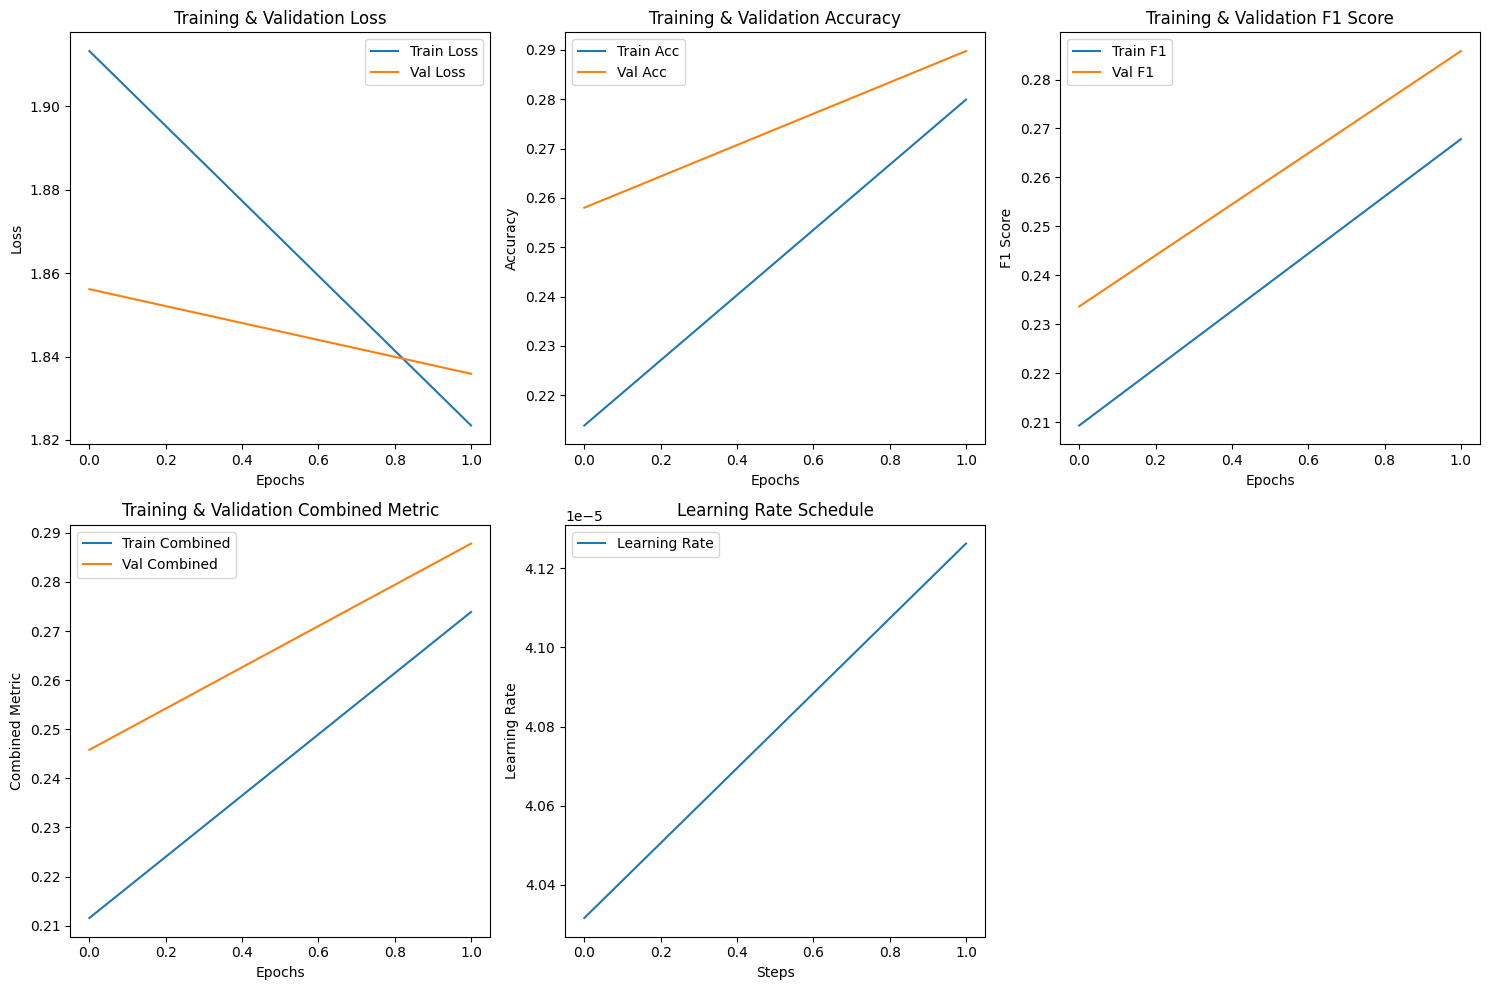

In [13]:
# Train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, patience=patience)

Accuracy: 0.3057
AUC Score: 0.6892
0.5*(Accuracy + F1) Score: 0.3048

Classification Report:
               precision    recall  f1-score   support

           0     0.2257    0.2220    0.2238       491
           1     0.0493    0.1818    0.0775        55
           2     0.1897    0.1402    0.1612       528
           3     0.4568    0.3606    0.4031       879
           4     0.3103    0.2273    0.2624       594
           5     0.3424    0.5745    0.4291       416
           6     0.3105    0.3403    0.3247       626

    accuracy                         0.3057      3589
   macro avg     0.2692    0.2924    0.2688      3589
weighted avg     0.3166    0.3057    0.3040      3589



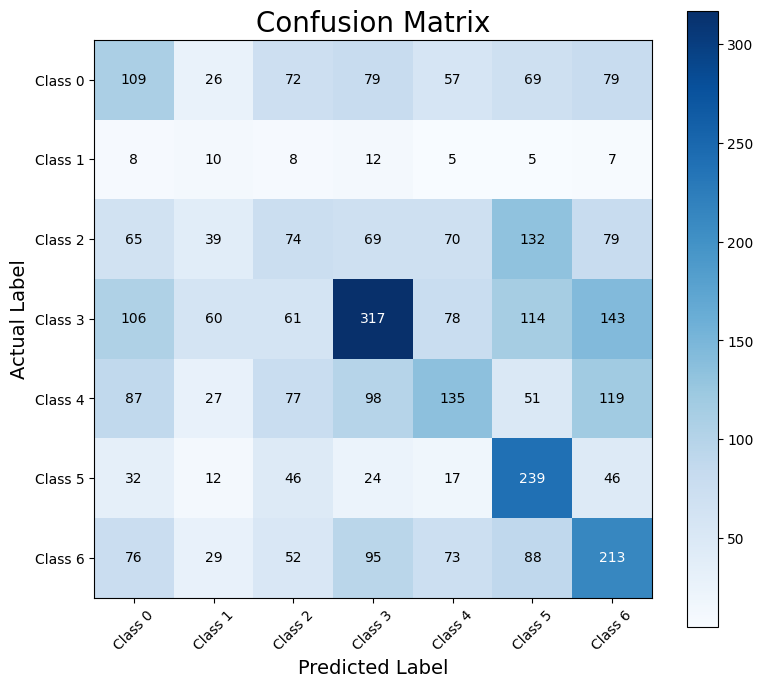

In [14]:
# Example usage:
cm, accuracy, auc_score, class_report, combined_metric = evaluate_model(model_ft, dataloaders['test'], num_classes=num_classes, device="cuda")

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print(f"0.5*(Accuracy + F1) Score: {combined_metric:.4f}")
print("\nClassification Report:\n", class_report)

# Plot confusion matrix
plot_confusion_matrix(cm, class_labels=[f"Class {i}" for i in range(num_classes)], normalize=False)

In [ ]:
visualize_model(model_ft)

### Variation 1 

Variation 1: Unfreeze classifier + last feature block

In [ ]:
def create_model_v1(num_classes, device):
    model_v1 = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
    num_ftrs = model_v1.classifier[1].in_features

    # Define custom classifier
    model_v1.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, num_classes)
    )

    # Freeze entire model first
    for param in model_v1.parameters():
        param.requires_grad = False

    # Unfreeze classifier
    for param in model_v1.classifier.parameters():
        param.requires_grad = True

    # Unfreeze last feature block (features[7] in EfficientNet-V2-S)
    for param in model_v1.features[7].parameters():
        param.requires_grad = True

    return model_v1.to(device)

In [ ]:
# Model 1 training
model_v1 = create_model_v1(num_classes, device)
criterion_v1 = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
optimizer_v1 = optim.AdamW(filter(lambda p: p.requires_grad, model_v1.parameters()), 
                         lr=lr, weight_decay=weight_decay)
scheduler_v1 = OneCycleLR(optimizer_v1, 
                         max_lr=1e-3, 
                         steps_per_epoch=len(dataloaders['train']), 
                         epochs=num_epochs, 
                         pct_start=0.1)

In [ ]:
model_v1 = train_model(model_v1, criterion_v1, optimizer_v1, scheduler_v1, num_epochs=num_epochs, patience=patience)

#### Train and evaluate

In [ ]:
# Example usage:
cm, accuracy, auc_score, class_report, combined_metric = evaluate_model(model_v1, dataloaders['test'], num_classes=num_classes, device="cuda")

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print(f"0.5*(Accuracy + F1) Score: {combined_metric:.4f}")

print("\nClassification Report:\n", class_report)

# Plot confusion matrix
plot_confusion_matrix(cm, class_labels=[f"Class {i}" for i in range(num_classes)], normalize=False)

In [ ]:
visualize_model(model_v1)

### Variation 2

Unfreeze classifier + last two feature blocks

In [ ]:
# Variation 2: Unfreeze classifier + last two feature blocks
def create_model_v2(num_classes, device):
    model_v2 = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
    num_ftrs = model_v2.classifier[1].in_features

    # Define custom classifier
    model_v2.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, num_classes)
    )

    # Freeze entire model first
    for param in model_v2.parameters():
        param.requires_grad = False

    # Unfreeze classifier
    for param in model_v2.classifier.parameters():
        param.requires_grad = True

    # Unfreeze last two feature blocks (features[6] and features[7])
    for block in [6, 7]:
        for param in model_v2.features[block].parameters():
            param.requires_grad = True

    return model_v2.to(device)

In [ ]:
# Model 2 training
model_v2 = create_model_v2(num_classes, device)
criterion_v2 = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
optimizer_v2 = optim.AdamW(filter(lambda p: p.requires_grad, model_v2.parameters()), 
                         lr=lr, weight_decay=weight_decay)
scheduler_v2 = OneCycleLR(optimizer_v2, 
                         max_lr=1e-3, 
                         steps_per_epoch=len(dataloaders['train']), 
                         epochs=num_epochs, 
                         pct_start=0.1)

In [ ]:
model_v2 = train_model(model_v2, criterion_v2, optimizer_v2, scheduler_v2, num_epochs=num_epochs, patience=patience)

#### Train and evaluate

In [ ]:
cm, accuracy, auc_score, class_report, combined_metric = evaluate_model(model_v2, dataloaders['test'], num_classes=num_classes, device="cuda")

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print(f"0.5*(Accuracy + F1) Score: {combined_metric:.4f}")
print("\nClassification Report:\n", class_report)

# Plot confusion matrix
plot_confusion_matrix(cm, class_labels=[f"Class {i}" for i in range(num_classes)], normalize=False)

In [ ]:
visualize_model(model_v2)